In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [3]:
df = pd.read_csv("https://olinda.bcb.gov.br/olinda/servico/SPI/versao/v1/odata/PixLiquidadosAtual?$top=5000&$orderby=Data%20asc&$format=text/csv", decimal=',')

In [398]:
pix = df.copy()
pix.columns = ['Date', 'Quantity', 'Total', 'Mean']
pix = pix.set_index(pd.to_datetime(pix['Date'])).drop('Date', axis=1)

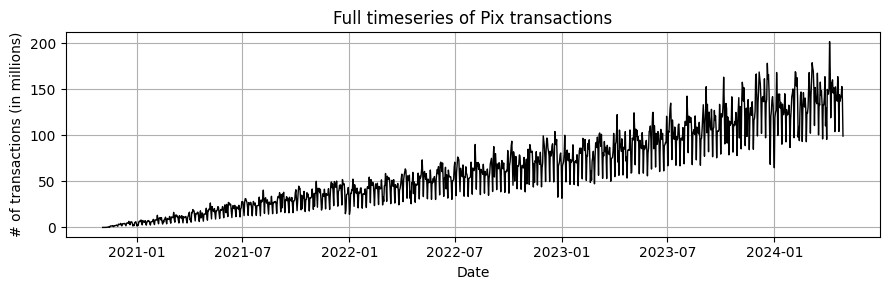

In [481]:
f, ax = plt.subplots(figsize=(9,3))
ax.plot(pix.index.values, pix['Quantity']/1e6, c='k', lw=1)

ax.set_xlabel('Date')
ax.set_ylabel('# of transactions (in millions)')
ax.set_title('Full timeseries of Pix transactions')

ax.grid(True)

plt.tight_layout()
plt.savefig('10.2-full_dataset.png')
plt.show()

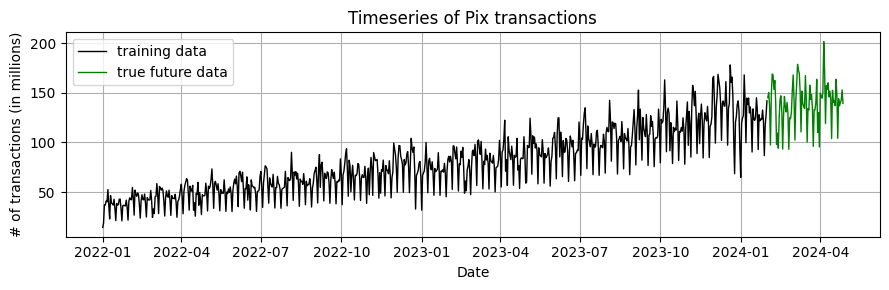

In [489]:
column = 'Quantity'

data = pix[[column]].copy()
data[column] = data[column]/1e6

data = data.resample('D').sum().ffill()

y_hist = data['2022-01-01':'2024-01-31']
y_futr = data['2024-02-01':'2024-04-27']

f, ax = plt.subplots(figsize=(9,3))

ax.plot(y_hist.index, y_hist[column], c='k', lw=1, label = 'training data')
ax.plot(y_futr.index, y_futr[column], c='g', lw=1, label = 'true future data')

ax.set_xlabel('Date')
ax.set_ylabel('# of transactions (in millions)')
ax.set_title('Timeseries of Pix transactions')

ax.grid(True)

ax.legend()

plt.tight_layout()
plt.savefig('10.2-cut_dataset.png')
plt.show()

In [444]:
pix.index.min()

Timestamp('2020-11-03 00:00:00')

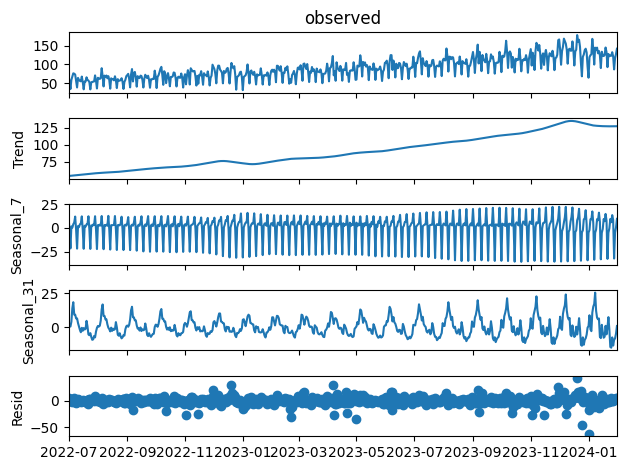

(-8.615358441648672,
 6.312067713688974e-14,
 13,
 566,
 {'1%': -3.441956369604407,
  '5%': -2.8666599744723045,
  '10%': -2.5694967895716014},
 3840.591778174006)

In [446]:
stl = MSTL(y_hist, periods=[7, 31], iterate=5, stl_kwargs={"seasonal": 311, "inner_iter": 1, "outer_iter": 1})
results = stl.fit()
results.plot()
plt.show()
display(adfuller(results.resid))

In [389]:
y_hist.shape

(580, 1)

MAE: 10.630493837733392
RMSE: 15.017076413874765


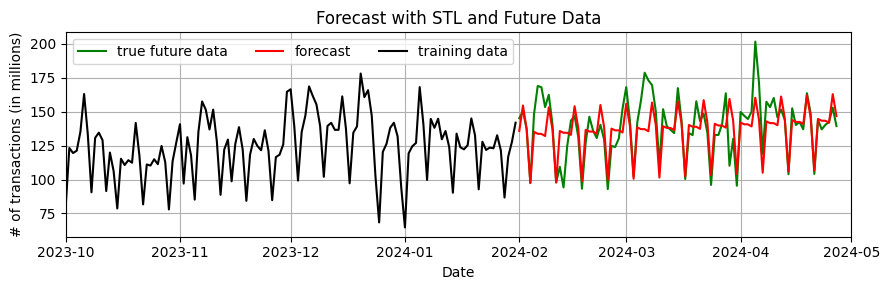

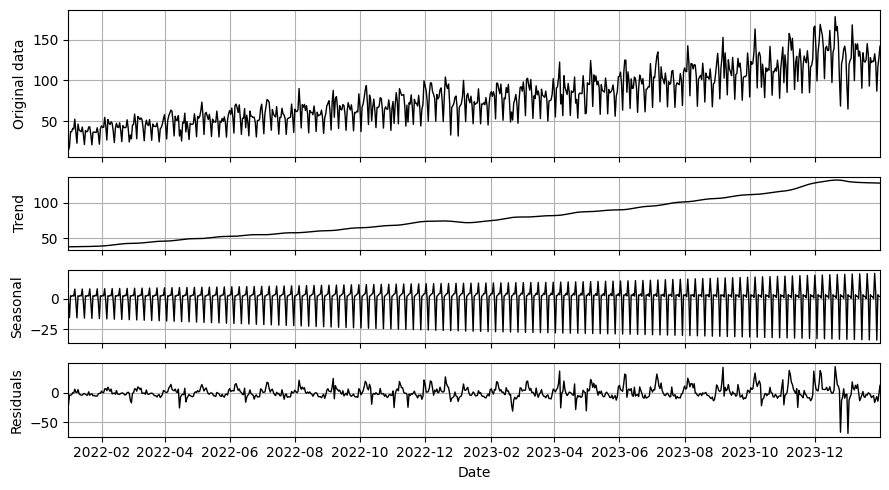

In [493]:
stlf = STLForecast(y_hist, ARIMA, seasonal=61, trend=71, robust=True, seasonal_deg=1, trend_deg=0, trend_jump=1, model_kwargs={'order':(1, 1, 1), 'trend':"t"}, period = 7)
stlf_results = stlf.fit()
forecast = stlf_results.forecast(len(y_futr))

pred_error = y_futr[column].values - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

plt.figure(figsize=(9,3))
plt.plot(y_futr, c='g', label = 'true future data')
plt.plot(forecast, c='r', label = 'forecast')
plt.plot(y_hist['2023-10-01':], c='k', label = 'training data')

plt.xlim(['2023-10-01', '2024-05-01'])

plt.title('Forecast with STL and Future Data')

plt.xlabel('Date')
plt.ylabel('# of transactions (in millions)')

plt.legend(ncols=3)

plt.grid()
plt.tight_layout()
plt.savefig('10.2-forecast.png')
plt.show()

plot_components(stlf_results.result)

In [492]:
import matplotlib.dates as mdates

def plot_components(df):
    f, axl = plt.subplots(4, 1, figsize=(9,5), sharex=True, height_ratios=[2,1,1,1])

    for ax in axl:
        ax.grid()
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # f.suptitle('Air passengers')
    
    ax = axl[0]
    ax.set_ylabel('Original data')
    ax.plot(df.observed, c='k', lw=1, label = 'original')

    ax = axl[1]
    ax.set_ylabel('Trend')
    ax.plot(df.trend, c='k', lw=1, label = 'trend')

    ax = axl[2]
    ax.set_ylabel('Seasonal')
    ax.plot(df.seasonal, c='k', lw=1, label = 'seasonal')

    ax = axl[3]
    ax.set_ylabel('Residuals')
    ax.plot(df.resid, c='k', lw=1, label = 'residuals')

    ax.set_xlim([df.observed.index.min(), df.observed.index.max()])

    f.gca().set_xlabel('Date')

    f.tight_layout()
    f.show()


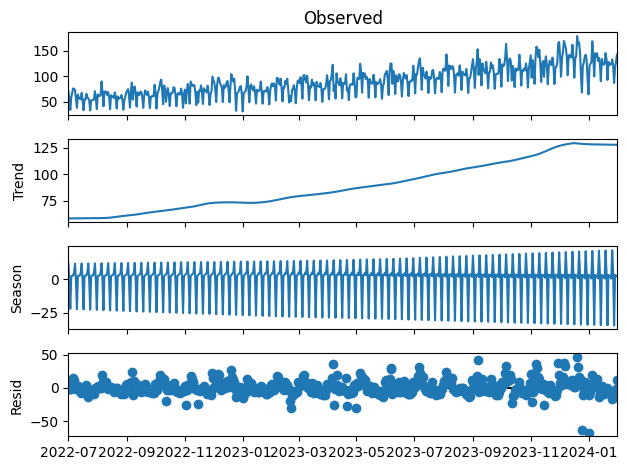

In [466]:
stlf_results.result.plot()
plt.show()

In [494]:
adfuller(stlf_results.result.resid)

(-10.136189419079061,
 8.657024712873919e-18,
 18,
 742,
 {'1%': -3.4391937559530965,
  '5%': -2.8654430713273373,
  '10%': -2.568848417404698},
 5260.692210732363)